In [1]:
import sys

import itertools
from keras.layers import Input, Dense, Reshape, Flatten
from keras import layers, initializers
from keras.models import Model, load_model
import keras.backend as K
import tensorflow as tf
import numpy as np
from seqtools import SequenceTools as ST
from gfp_gp import SequenceGP
from util import AA, AA_IDX
from util import build_vae
from sklearn.model_selection import train_test_split, ShuffleSplit
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
from gan import WGAN
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize
from keras.utils.generic_utils import get_custom_objects
from util import one_hot_encode_aa, partition_data, get_balaji_predictions, get_samples, get_argmax
from util import convert_idx_array_to_aas, build_pred_vae_model, get_experimental_X_y
from util import get_gfp_X_y_aa
from losses import neg_log_likelihood
import json

import isolearn.io as isoio
import isolearn.keras as isol

from genesis_generator_protein import *
from genesis_predictor_protein import *

from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, CuDNNLSTM, ConvLSTM2D, GRU, CuDNNGRU, Bidirectional, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply

import warnings
warnings.filterwarnings("ignore")

def build_loss_model(predictor_model, loss_func, extra_loss_tensors=[]) :

    loss_out = Lambda(lambda out: loss_func(out), output_shape = (1,))(predictor_model.inputs + predictor_model.outputs + extra_loss_tensors)

    loss_model = Model(predictor_model.inputs, loss_out)

    return 'loss_model', loss_model

def build_model(M):
    x = Input(shape=(M, 20,))
    y = Flatten()(x)
    y = Dense(50, activation='elu')(y)
    y = Dense(2)(y)
    model = Model(inputs=x, outputs=y)
    return model

import editdistance

def compute_edit_distance(seqs, opt_len=None) :
    shuffle_index = np.arange(len(seqs))
    shuffle_index = shuffle_index[::-1]
    
    seqs_shuffled = [seqs[shuffle_index[i]] for i in range(len(seqs))]
    edit_distances = np.ravel([float(editdistance.eval(seq_1, seq_2)) for seq_1, seq_2 in zip(seqs, seqs_shuffled)])
    if opt_len is not None :
        edit_distances /= opt_len
    
    return edit_distances

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

def get_z_sample_numpy(z_mean, z_log_var, n_samples=1) :
    
    n = z_mean.shape[0]
    m = z_mean.shape[2]
    
    epsilon = np.random.normal(loc=0., scale=1., size=(n, n_samples, m))
    
    return z_mean + np.exp(0.5 * z_log_var) * epsilon

#Evaluate VAE Likelihood (ELBO) on supplied data
def evaluate_elbo(vae_encoder_model, vae_decoder_model, sequence_one_hots, pwm_start=0, pwm_end=-1, n_samples=1, decoded_pwm_eps=1e-6) :
    _epsilon = 10**-6
    
    if pwm_end == -1 :
        pwm_end = sequence_one_hots.shape[2]
    
    #Get sequence VAE encodings
    z_mean, z_log_var = vae_encoder_model.predict(x=sequence_one_hots, batch_size=32, verbose=False)

    z_mean = np.tile(np.expand_dims(z_mean, axis=1), (1, n_samples, 1))
    z_log_var = np.tile(np.expand_dims(z_log_var, axis=1), (1, n_samples, 1))
    z = get_z_sample_numpy(z_mean, z_log_var, n_samples=n_samples)
    
    #Get re-decoded sequence PWMs
    decoded_pwms = np.zeros((sequence_one_hots.shape[0], n_samples) + sequence_one_hots.shape[1:])

    for sample_ix in range(n_samples) :
        decoded_pwms[:, sample_ix, :, :] = vae_decoder_model.predict(x=z[:, sample_ix, :], batch_size=32, verbose=False)

    decoded_pwms = np.clip(decoded_pwms, decoded_pwm_eps, 1. - decoded_pwm_eps)
    
    sequence_one_hots_expanded = np.tile(np.expand_dims(sequence_one_hots, axis=1), (1, n_samples, 1, 1))
    
    #Calculate reconstruction log prob
    log_p_x_given_z = np.sum(np.sum(sequence_one_hots_expanded[:, :, pwm_start:pwm_end, :] * np.log(np.clip(decoded_pwms[:, :, pwm_start:pwm_end, :], _epsilon, 1. - _epsilon)) / np.log(10.), axis=3), axis=2)

    #Calculate standard normal and importance log probs
    log_p_std_normal = np.sum(norm.logpdf(z, 0., 1.) / np.log(10.), axis=-1)
    log_p_importance = np.sum(norm.logpdf(z, z_mean, np.sqrt(np.exp(z_log_var))) / np.log(10.), axis=-1)

    #Calculate per-sample ELBO
    log_p_vae = log_p_x_given_z + log_p_std_normal - log_p_importance
    log_p_vae_div_n = log_p_vae - np.log(n_samples) / np.log(10.)

    #Calculate mean ELBO across samples (log-sum-exp trick)
    max_log_p_vae = np.max(log_p_vae_div_n, axis=-1)
    
    log_mean_p_vae = max_log_p_vae + np.log(np.sum(10**(log_p_vae_div_n - np.expand_dims(max_log_p_vae, axis=-1)), axis=-1)) / np.log(10.)
    mean_log_p_vae = np.mean(log_mean_p_vae)
    
    return log_mean_p_vae, mean_log_p_vae, log_p_vae


Instructions for updating:
Colocations handled automatically by placer.
mean log(likelihood) = -0.8908
mode log(likelihood) = -0.1512


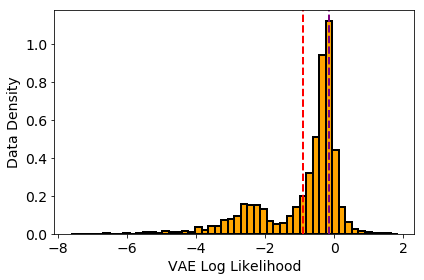

In [3]:
#Evaluate ELBO distribution on GFP dataset, decoder epsilon = 1e-6

n_z_samples = 128

it = 0
TRAIN_SIZE = 5000
train_size_str = "%ik" % (TRAIN_SIZE/1000)
num_models = [1, 5, 20][it]
RANDOM_STATE = it + 1

X_train, y_train, gt_train  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)

L = X_train.shape[1]

vae_suffix = '_%s_%i' % (train_size_str, RANDOM_STATE)

vae_0 = build_vae(latent_dim=20, n_tokens=20, seq_length=L, enc1_units=50)

vae_0.encoder_.load_weights("models/vae_0_encoder_weights%s.h5" % vae_suffix)
vae_0.decoder_.load_weights("models/vae_0_decoder_weights%s.h5"% vae_suffix)
vae_0.vae_.load_weights("models/vae_0_vae_weights%s.h5"% vae_suffix)

#Compute multi-sample ELBO on test set
log_mean_p_vae_test, mean_log_p_vae_test, log_p_vae_test = evaluate_elbo(vae_0.encoder_, vae_0.decoder_, X_train, n_samples=n_z_samples)

#Log Likelihood Plot
plot_min_val = None
plot_max_val = None

f = plt.figure(figsize=(6, 4))

log_p_vae_test_hist, log_p_vae_test_edges = np.histogram(log_mean_p_vae_test, bins=50, density=True)
bin_width_test = log_p_vae_test_edges[1] - log_p_vae_test_edges[0]

mean_log_p_vae_test = np.mean(log_mean_p_vae_test)
mode_log_p_vae_test = log_p_vae_test_edges[np.argmax(log_p_vae_test_hist)] + bin_width_test / 2.

print("mean log(likelihood) = " + str(round(mean_log_p_vae_test, 4)))
print("mode log(likelihood) = " + str(round(mode_log_p_vae_test, 4)))


plt.bar(log_p_vae_test_edges[1:] - bin_width_test/2., log_p_vae_test_hist, width=bin_width_test, linewidth=2, edgecolor='black', color='orange')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if plot_min_val is not None and plot_max_val is not None :
    plt.xlim(plot_min_val, plot_max_val)

plt.xlabel("VAE Log Likelihood", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.axvline(x=mean_log_p_vae_test, linewidth=2, color='red', linestyle="--")
plt.axvline(x=mode_log_p_vae_test, linewidth=2, color='purple', linestyle="--")

plt.tight_layout()
plt.show()


In [3]:
#GFP Generator Model definition

def get_load_generator_network(seed_mode='new', rand_mode='uniform') :

    def _load_generator_network(batch_size, sequence_class, n_classes=1, n_out_channels=20, seq_length=237, supply_inputs=False, seed_mode=seed_mode, rand_mode=rand_mode) :

        sequence_class_onehots = np.eye(n_classes)

        #Generator network parameters
        latent_size = 100

        init_seq_length = 256 // 8
        unclipped_seq_length = 256

        #Generator inputs
        latent_input_1 = None
        latent_input_2 = None
        latent_input_1_out = None
        latent_input_2_out = None
        if seed_mode == 'new' :
            latent_input_1 = Input(tensor=K.ones((batch_size, latent_size)), name='noise_input_1')
            latent_input_2 = Input(tensor=K.ones((batch_size, latent_size)), name='noise_input_2')
            if rand_mode == 'uniform' :
                latent_input_1_out = Lambda(lambda inp: inp * K.random_uniform((batch_size, latent_size), minval=-1.0, maxval=1.0), name='lambda_rand_input_1')(latent_input_1)
                latent_input_2_out = Lambda(lambda inp: inp * K.random_uniform((batch_size, latent_size), minval=-1.0, maxval=1.0), name='lambda_rand_input_2')(latent_input_2)
            elif rand_mode == 'normal' :
                latent_input_1_out = Lambda(lambda inp: inp * K.random_normal((batch_size, latent_size)), name='lambda_rand_input_1')(latent_input_1)
                latent_input_2_out = Lambda(lambda inp: inp * K.random_normal((batch_size, latent_size)), name='lambda_rand_input_2')(latent_input_2)
        elif seed_mode == 'fixed' :
            if rand_mode == 'uniform' :
                latent_input_1 = Input(tensor=K.variable(K.random_uniform((batch_size, latent_size))), name='noise_input_1')
                latent_input_2 = Input(tensor=K.variable(K.random_uniform((batch_size, latent_size))), name='noise_input_2')
            elif rand_mode == 'normal' :
                latent_input_1 = Input(tensor=K.variable(K.random_normal((batch_size, latent_size))), name='noise_input_1')
                latent_input_2 = Input(tensor=K.variable(K.random_normal((batch_size, latent_size))), name='noise_input_2')

            latent_input_1_out = Lambda(lambda inp: inp, name='lambda_rand_input_1')(latent_input_1)
            latent_input_2_out = Lambda(lambda inp: inp, name='lambda_rand_input_2')(latent_input_2)

        class_embedding = Lambda(lambda x: K.gather(K.constant(sequence_class_onehots), K.cast(x[:, 0], dtype='int32')))(sequence_class)

        seed_input_1 = Concatenate(axis=-1)([latent_input_1_out, class_embedding])
        seed_input_2 = Concatenate(axis=-1)([latent_input_2_out, class_embedding])


        #Policy network definition
        policy_dense_1 = Dense(init_seq_length * 384, activation='relu', kernel_initializer='glorot_uniform', name='policy_dense_1')

        policy_dense_1_reshape = Reshape((init_seq_length, 1, 384))

        policy_deconv_0 = Conv2DTranspose(256, (8, 1), strides=(2, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_deconv_0')

        policy_deconv_1 = Conv2DTranspose(192, (8, 1), strides=(2, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_deconv_1')

        policy_deconv_2 = Conv2DTranspose(128, (8, 1), strides=(2, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_deconv_2')

        policy_recurrent_collapse = Lambda(lambda x: x[:, :, 0, :])

        policy_recurrent_4 = CuDNNLSTM(n_out_channels, return_sequences=True, name='policy_recurrent_4')

        policy_recurrent_expand = Lambda(lambda x: K.expand_dims(x, axis=2))

        batch_norm_0 = BatchNormalization(name='policy_batch_norm_0')
        relu_0 = Lambda(lambda x: K.relu(x))
        batch_norm_1 = BatchNormalization(name='policy_batch_norm_1')
        relu_1 = Lambda(lambda x: K.relu(x))
        batch_norm_2 = BatchNormalization(name='policy_batch_norm_2')
        relu_2 = Lambda(lambda x: K.relu(x))

        batch_norm_scale = BatchNormalization(name='policy_batch_norm_scale')
        policy_conv_scale = Conv2D(n_out_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_conv_scale')

        policy_out_1 = Lambda(lambda x: x[:, :seq_length, ...])(Reshape((unclipped_seq_length, n_out_channels, 1))(policy_conv_scale(batch_norm_scale(policy_recurrent_expand(policy_recurrent_4(policy_recurrent_collapse(relu_2(batch_norm_2(policy_deconv_2(relu_1(batch_norm_1(policy_deconv_1(relu_0(batch_norm_0(policy_deconv_0(policy_dense_1_reshape(policy_dense_1(seed_input_1))), training=True))), training=True))), training=True))))), training=True))))
        policy_out_2 = Lambda(lambda x: x[:, :seq_length, ...])(Reshape((unclipped_seq_length, n_out_channels, 1))(policy_conv_scale(batch_norm_scale(policy_recurrent_expand(policy_recurrent_4(policy_recurrent_collapse(relu_2(batch_norm_2(policy_deconv_2(relu_1(batch_norm_1(policy_deconv_1(relu_0(batch_norm_0(policy_deconv_0(policy_dense_1_reshape(policy_dense_1(seed_input_2))), training=True))), training=True))), training=True))))), training=True))))

        return [latent_input_1, latent_input_2], [policy_out_1, policy_out_2], []
    
    return _load_generator_network


In [4]:
#GFP Oracle Model definition

def load_saved_predictor(model_path, seq_len, oracle_suffix, random_state, num_models) :

    saved_oracles = [build_model(seq_len) for i in range(num_models)]
    for i in range(num_models) :
        saved_oracles[i].load_weights(model_path + "oracle_%i%s.h5" % (random_state, oracle_suffix))
    
    def _initialize_predictor_weights(predictor_model, saved_oracles=saved_oracles) :
        #Load pre-trained weights
        for i in range(len(saved_oracles)) :
            
            dense_1_name = 'dense_1'
            dense_2_name = 'dense_2'
            
            curr_dense_found = 0
            for saved_layer in saved_oracles[i].layers :
                if 'dense_' in saved_layer.name :
                    if curr_dense_found == 0 :
                        dense_1_name = saved_layer.name
                        curr_dense_found += 1
                    elif curr_dense_found == 1 :
                        dense_2_name = saved_layer.name
                        curr_dense_found += 1
            
            predictor_model.get_layer('gfp_' + str(i) + '_' + str(num_models) + '_dense_1').set_weights(saved_oracles[i].get_layer(dense_1_name).get_weights())
            predictor_model.get_layer('gfp_' + str(i) + '_' + str(num_models) + '_dense_1').trainable = False
            
            predictor_model.get_layer('gfp_' + str(i) + '_' + str(num_models) + '_dense_2').set_weights(saved_oracles[i].get_layer(dense_2_name).get_weights())
            predictor_model.get_layer('gfp_' + str(i) + '_' + str(num_models) + '_dense_2').trainable = False

    def _load_predictor_func(sequence_input, sequence_class, random_state=random_state, num_models=num_models) :
        
        #Build single model
        def build_model(x, i, num_models) :
            y = Flatten()(x)
            y = Dense(50, activation='elu', name='gfp_' + str(i) + '_' + str(num_models) + '_dense_1')(y)
            y = Dense(2, name='gfp_' + str(i) + '_' + str(num_models) + '_dense_2')(y)
            y = Lambda(lambda yy: K.concatenate([K.expand_dims(K.expand_dims(yy[:, 0], axis=-1), axis=-1), K.expand_dims(K.expand_dims(K.log(1.+K.exp(yy[:, 1])) + K.epsilon(), axis=-1), axis=-1)], axis=1))(y)
            return y
        
        oracles = [build_model(sequence_input, i, num_models) for i in range(num_models)]
        
        oracles_mean = None
        oracles_var = None
        if len(oracles) > 1 :
            oracles_concat = Concatenate(axis=-1)(oracles)
            oracles_means = Lambda(lambda y: y[:, 0, :])(oracles_concat)
            oracles_vars = Lambda(lambda y: y[:, 1, :])(oracles_concat)
            oracles_mean = Lambda(lambda y: K.expand_dims(K.mean(y, axis=-1), axis=-1))(oracles_means)
            oracles_var = Lambda(lambda l: (1. / K.constant(num_models)) * (K.expand_dims(K.sum(l[1], axis=-1), axis=-1) + K.expand_dims(K.sum(l[0]**2, axis=-1), axis=-1)) - l[2]**2)([oracles_means, oracles_vars, oracles_mean])
        else :
            oracles_mean = Lambda(lambda y: K.expand_dims(y[:, 0, 0], axis=-1))(oracles[0])
            oracles_var = Lambda(lambda y: K.expand_dims(y[:, 1, 0], axis=-1))(oracles[0])

        predictor_inputs = []
        predictor_outputs = [oracles_mean, oracles_var]

        return predictor_inputs, predictor_outputs, _initialize_predictor_weights

    return _load_predictor_func


In [5]:
from keras.callbacks import Callback

class PredictorCallback(Callback):
    def __init__(self, generator_model, oracles, ground_truth, n_epochs=10, n_sequences=32, batch_size=32) :
        self.generator_model = generator_model
        self.oracles = oracles
        self.ground_truth = ground_truth
        self.batch_size = batch_size
        self.n_sequences = n_sequences
        
        self.traj = np.zeros((n_epochs + 1, 7))
        self.oracle_samples = np.zeros((n_epochs + 1, n_sequences))
        self.gt_samples = np.zeros((n_epochs + 1, n_sequences))
        self.edit_distance_samples = np.zeros((n_epochs + 1, n_sequences))
        
        self.oracle_max = -np.inf
        self.gt_of_oracle_max = -np.inf
        self.oracle_max_seq = ''
        
        self._predict_sequences(0)
    
    def _predict_sequences(self, epoch) :
        n_batches = self.n_sequences // self.batch_size
        
        gen_bundle = self.generator_model.predict(x=None, steps=n_batches)
        
        _, _, _, _, _, sampled_pwm, _, _, _ = gen_bundle
        
        onehots = sampled_pwm[:, 0, :, :, 0]
        onehots_aa = np.argmax(onehots, axis=-1)
        
        yt_sample, _ = get_balaji_predictions(self.oracles, onehots)
        yt_gt_sample = self.ground_truth.predict(onehots_aa, print_every=1000000)[:, 0]
        
        rand_idx = np.random.randint(0, len(yt_sample), self.n_sequences)
        self.oracle_samples[epoch, :] = yt_sample[rand_idx]
        self.gt_samples[epoch, :] = yt_gt_sample[rand_idx]
        
        self.edit_distance_samples[epoch, :] = compute_edit_distance(convert_idx_array_to_aas(onehots_aa))

        self.traj[epoch, 0] = np.max(yt_gt_sample)
        self.traj[epoch, 1] = np.mean(yt_gt_sample)
        self.traj[epoch, 2] = np.std(yt_gt_sample)
        self.traj[epoch, 3] = np.max(yt_sample)
        self.traj[epoch, 4] = np.mean(yt_sample)
        self.traj[epoch, 5] = np.std(yt_sample)
        if epoch > 0:
            self.traj[epoch, 6] = 0
        else:
            self.traj[epoch, 6] = 0
        
        yt_max = np.max(yt_sample)
        
        print(" - Oracle (80-th perc.) = " + str(round(np.percentile(yt_sample, 80), 4)))
        print(" - Ground-thruth (80-th perc.) = " + str(round(np.percentile(yt_gt_sample, 80), 4)))
        print(" - Ground-thruth (95-th perc.) = " + str(round(np.percentile(yt_gt_sample, 95), 4)))
        print(" - Ground-thruth (100-th perc.) = " + str(round(np.percentile(yt_gt_sample, 100), 4)))
        
        print(" - Edit distance (median) = " + str(round(np.median(self.edit_distance_samples[epoch, :]), 4)))
        
        if yt_max > self.oracle_max :
            yt_max_idx = np.argmax(yt_sample)
            self.oracle_max = yt_max
            self.gt_of_oracle_max = yt_gt_sample[yt_max_idx]
            self.oracle_max_seq = convert_idx_array_to_aas(np.expand_dims(onehots_aa[yt_max_idx], axis=0))[0]
    
    def on_epoch_end(self, epoch, logs={}) :
        
        self._predict_sequences(epoch + 1)

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

class InputSeedCallback(Callback) :
    def __init__(self, model, n_sequences=128, n_sequences_per_epoch=32, latent_size=100, batch_size=64, rand_mode='uniform') :
        self.model = model
        self.seed_1 = self.model.get_layer("noise_input_1").input
        self.seed_2 = self.model.get_layer("noise_input_2").input
        
        self.n_sequences = n_sequences
        self.n_sequences_per_epoch = n_sequences_per_epoch
        self.n_batches = self.n_sequences // batch_size
        self.n_batches_per_epoch = self.n_sequences_per_epoch // batch_size
        self.batch_size = batch_size
        self.latent_size = latent_size
        self.rand_mode = rand_mode
        
        self.seed_1_data = [
            (np.random.normal(size=(self.batch_size, latent_size)) if self.rand_mode == 'normal' else np.random.uniform(size=(self.batch_size, latent_size)))
            for batch_i in range(self.n_batches)
        ]
        self.seed_2_data = [
            (np.random.normal(size=(self.batch_size, latent_size)) if self.rand_mode == 'normal' else np.random.uniform(size=(self.batch_size, latent_size)))
            for batch_i in range(self.n_batches)
        ]
        
    def on_epoch_end(self, epoch, logs={}) :
        for batch_i in range(self.n_batches_per_epoch) :
            self.seed_1_data.pop()
            self.seed_2_data.pop()
        
        for batch_i in range(self.n_batches_per_epoch) :
            if self.rand_mode == 'normal' :
                self.seed_1_data.insert(0, np.random.normal(size=(self.batch_size, self.latent_size)))
                self.seed_2_data.insert(0, np.random.normal(size=(self.batch_size, self.latent_size)))
            elif self.rand_mode == 'uniform' :
                self.seed_1_data.insert(0, np.random.uniform(size=(self.batch_size, self.latent_size)))
                self.seed_2_data.insert(0, np.random.uniform(size=(self.batch_size, self.latent_size)))
    
    def on_batch_end(self, batch, logs={}) :
        rand_ix_1 = np.random.randint(low=0, high=self.n_batches)
        rand_ix_2 = np.random.randint(low=0, high=self.n_batches)
        
        K.set_value(self.seed_1, self.seed_1_data[rand_ix_1])
        K.set_value(self.seed_2, self.seed_2_data[rand_ix_2])


In [6]:
#Keras helper functions to calculate normal distribution log pdf
def normal_log_prob(x, loc=0., scale=1.) :
    return _normal_log_unnormalized_prob(x, loc, scale) - _normal_log_normalization(scale)

def _normal_log_unnormalized_prob(x, loc, scale):
    return -0.5 * K.square((x - loc) / scale)

def _normal_log_normalization(scale):
    return 0.5 * K.log(2. * K.constant(np.pi)) + K.log(scale)

#Keras function to sample latent vectors
def get_z_sample(z_inputs) :
    
    z_mean, z_log_var = z_inputs
    
    batch_size = K.shape(z_mean)[0]
    latent_dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#Keras function to sample (multiple) latent vectors
def get_z_samples(z_inputs, n_z_samples=1) :
    
    z_mean, z_log_var = z_inputs
    
    batch_size = K.shape(z_mean)[0]
    n_samples = K.shape(z_mean)[1]
    latent_dim = K.int_shape(z_mean)[3]
    
    epsilon = K.random_normal(shape=(batch_size, n_samples, n_z_samples, latent_dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#Code for constructing a (differentiable) VAE ELBO estimator in Keras
def build_den_vae(generator, vae_path, vae_suffix, build_vae_func, batch_size=1, seq_length=237, n_samples=1, n_z_samples=1, vae_latent_dim=100, vae_pwm_start=0, vae_pwm_end=-1, transform_adversary=False) :
    
    #Connect generated sequence samples from generator to vae
    generated_sequence_pwm = generator.outputs[3]
    generated_sequence_adv = generator.outputs[4]
    generated_sequence_samples = generator.outputs[5]
    generated_sequence_adv_samples = generator.outputs[6]
    
    if vae_pwm_end == -1 :
        vae_pwm_end = seq_length
    
    vae_0 = build_vae_func(latent_dim=20, n_tokens=20, seq_length=seq_length, enc1_units=50)

    vae_0.encoder_.load_weights(vae_path + "vae_0_encoder_weights%s.h5" % vae_suffix)
    vae_0.decoder_.load_weights(vae_path + "vae_0_decoder_weights%s.h5"% vae_suffix)
    vae_0.vae_.load_weights(vae_path + "vae_0_vae_weights%s.h5"% vae_suffix)
    
    #Freeze encoder model
    vae_0.encoder_.trainable = False
    vae_0.encoder_.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999))
    saved_vae_encoder_model = vae_0.encoder_
    
    #Load decoder model
    vae_0.decoder_.trainable = False
    vae_0.decoder_.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999))
    saved_vae_decoder_model = vae_0.decoder_
    
    #Construct vae elbo keras function (lambda layer)
    def _vae_elbo_func(pwm_and_sampled_pwm, batch_size=batch_size, n_samples=n_samples, n_z_samples=n_z_samples, transform_adversary=transform_adversary) :
        
        pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2 = pwm_and_sampled_pwm
        
        def _encode_and_sample(saved_vae_encoder_model, pwm, sampled_pwm, vae_pwm_start, vae_pwm_end, vae_latent_dim, n_z_samples) :
            vae_pwm = pwm[:, vae_pwm_start:vae_pwm_end, :, :]
            vae_sampled_pwm = sampled_pwm[:, :, vae_pwm_start:vae_pwm_end, :, :]
            
            vae_sampled_pwm_permuted = K.permute_dimensions(vae_sampled_pwm, (1, 0, 4, 2, 3))

            z_param_collection = tf.map_fn(lambda x_in: K.concatenate(saved_vae_encoder_model(x_in[:, 0, ...]), axis=-1)[..., :2*vae_latent_dim], vae_sampled_pwm_permuted, parallel_iterations=16)

            z_mean = K.permute_dimensions(z_param_collection[..., :vae_latent_dim], (1, 0, 2))
            z_log_var = K.permute_dimensions(z_param_collection[..., vae_latent_dim:2*vae_latent_dim], (1, 0, 2))

            z_mean = K.tile(K.expand_dims(z_mean, axis=2), (1, 1, n_z_samples, 1))
            z_log_var = K.tile(K.expand_dims(z_log_var, axis=2), (1, 1, n_z_samples, 1))

            z = get_z_samples([z_mean, z_log_var], n_z_samples=n_z_samples)
            
            return vae_pwm, vae_sampled_pwm, z_mean, z_log_var, z
        
        vae_pwm_1, vae_sampled_pwm_1, z_mean_1, z_log_var_1, z_1 = _encode_and_sample(saved_vae_encoder_model, pwm_1, sampled_pwm_1, vae_pwm_start, vae_pwm_end, vae_latent_dim, n_z_samples)
        
        if transform_adversary :
            vae_pwm_2, vae_sampled_pwm_2, z_mean_2, z_log_var_2, z_2 = _encode_and_sample(saved_vae_encoder_model, pwm_2, sampled_pwm_2, vae_pwm_start, vae_pwm_end, vae_latent_dim, n_z_samples)
            
        z_1_permuted = K.permute_dimensions(z_1, (1, 2, 0, 3))
        
        decoded_pwm_1 = tf.map_fn(lambda z_in: tf.map_fn(lambda z_in_in: saved_vae_decoder_model([z_in_in]), z_in, parallel_iterations=16), z_1_permuted, parallel_iterations=16)
        decoded_pwm_1 = K.expand_dims(decoded_pwm_1, axis=-3)
        decoded_pwm_1 = K.permute_dimensions(decoded_pwm_1, (2, 0, 1, 4, 5, 3))

        vae_pwm_tiled_1 = K.tile(K.expand_dims(vae_pwm_1, axis=1), (1, n_z_samples, 1, 1, 1))
        vae_sampled_pwm_tiled_1 = K.tile(K.expand_dims(vae_sampled_pwm_1, axis=2), (1, 1, n_z_samples, 1, 1, 1))

        if transform_adversary :
            return [vae_pwm_tiled_1, vae_sampled_pwm_tiled_1, z_mean_1, z_log_var_1, z_1, decoded_pwm_1, vae_pwm_2, vae_sampled_pwm_2, z_mean_2, z_log_var_2, z_2]
        else :
            return [vae_pwm_tiled_1, vae_sampled_pwm_tiled_1, z_mean_1, z_log_var_1, z_1, decoded_pwm_1]
    
    vae_elbo_layer = Lambda(_vae_elbo_func)
    
    #Call vae elbo estimator on generator sequences
    vae_elbo_outputs = vae_elbo_layer([generated_sequence_pwm, generated_sequence_adv, generated_sequence_samples, generated_sequence_adv_samples])
    
    return vae_elbo_outputs

In [7]:
from tensorflow.distributions import Normal as tf_normal
from tensorflow.contrib.distributions import percentile as tf_perc

def get_margin_entropy_ame(pwm_start=0, pwm_end=100, min_bits=1.0, n_channels=20) :
    
    def margin_entropy_ame(pwm) :
        pwm_section = pwm[:, pwm_start:pwm_end, :, :]
        entropy = pwm_section * -K.log(K.clip(pwm_section, K.epsilon(), 1. - K.epsilon())) / K.log(2.0)
        entropy = K.sum(entropy, axis=(2, 3))
        conservation = np.log2(n_channels) - entropy

        mean_conservation = K.mean(conservation, axis=-1)

        margin_conservation = K.switch(mean_conservation < K.constant(min_bits, shape=(1,)), K.constant(min_bits, shape=(1,)) - mean_conservation, K.zeros_like(mean_conservation))
    
        return margin_conservation
    
    return margin_entropy_ame

def get_pwm_margin_sample_entropy(pwm_start=0, pwm_end=100, margin=0.5, shift_1_nt=False) : 

    def pwm_margin_sample_entropy(pwm1, pwm2) :
        sampled_pwm_1 = pwm1[..., pwm_start:pwm_end, :, :]
        sampled_pwm_2 = pwm2[..., pwm_start:pwm_end, :, :]
        
        mean_sample_ent = K.mean(K.sum(sampled_pwm_1 * sampled_pwm_2, axis=(-2, -1)), axis=-1)
        mean_sample_ent_shift_l_1 = K.mean(K.sum(sampled_pwm_1[..., 1:, :, :] * sampled_pwm_2[..., :-1, :, :], axis=(-2, -1)), axis=-1)
        mean_sample_ent_shift_r_1 = K.mean(K.sum(sampled_pwm_1[..., :-1, :, :] * sampled_pwm_2[..., 1:, :, :], axis=(-2, -1)), axis=-1)
        
        margin_sample_ent = K.switch(mean_sample_ent > K.constant(margin, shape=(1,)), mean_sample_ent - margin, K.zeros_like(mean_sample_ent))
        margin_sample_ent_l_1 = K.switch(mean_sample_ent_shift_l_1 > K.constant(margin, shape=(1,)), mean_sample_ent_shift_l_1 - margin, K.zeros_like(mean_sample_ent))
        margin_sample_ent_r_1 = K.switch(mean_sample_ent_shift_r_1 > K.constant(margin, shape=(1,)), mean_sample_ent_shift_r_1 - margin, K.zeros_like(mean_sample_ent))
        
        if shift_1_nt :
            return margin_sample_ent + margin_sample_ent_l_1 + margin_sample_ent_r_1
        else :
            return margin_sample_ent

    return pwm_margin_sample_entropy

#Define DEN loss function
def get_den_loss(target_val, fitness_weight=1.0, fitness_loss_mode='target', seq_length=237, pwm_start=0, pwm_end=237, n_samples=1, n_z_samples=1, batch_size=32, mini_batch_size=1, vae_loss_mode='bound', vae_divergence_weight=1., ref_vae_log_p=-10, vae_log_p_margin=1, decoded_pwm_eps=1e-6, pwm_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5, include_sf_grad_at_quantile=0.7) :
    
    pwm_entropy_mse = get_margin_entropy_ame(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    sample_entropy_func = get_pwm_margin_sample_entropy(pwm_start=pwm_start, pwm_end=pwm_end, margin=similarity_margin, shift_1_nt=True)
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, score_pred, var_pred, vae_pwm_1, vae_sampled_pwm_1, z_mean_1, z_log_var_1, z_1, decoded_pwm_1 = loss_tensors
        
        #Specify costs
        
        fitness_loss = 0.
        if fitness_loss_mode == 'bound' :
            fitness_loss = fitness_weight * K.mean(K.maximum(-score_pred[..., 0] + target_val, K.zeros_like(score_pred[..., 0])), axis=1)
        elif fitness_loss_mode == 'target' :
            fitness_loss = fitness_weight * K.mean(K.abs(score_pred[..., 0] - target_val), axis=1)
        elif fitness_loss_mode == 'mini_batch_bound' :
            mini_batch_fitness_score = K.permute_dimensions(K.reshape(score_pred[..., 0], (int(batch_size / mini_batch_size), mini_batch_size, n_samples)), (0, 2, 1))
            mini_batch_mean_fitness_score = K.mean(mini_batch_fitness_score, axis=-1)
            tiled_mini_batch_mean_fitness_score = K.tile(mini_batch_mean_fitness_score, (mini_batch_size, 1))
            
            fitness_loss = fitness_weight * K.mean(K.maximum(-tiled_mini_batch_mean_fitness_score + target_val, K.zeros_like(tiled_mini_batch_mean_fitness_score)), axis=1)
        elif fitness_loss_mode == 'log_sf' :
            fitness_distr_w_var_grad = tf_normal(loc=score_pred[..., 0], scale=K.sqrt(var_pred[..., 0]))
            fitness_log_sf_w_var_grad = fitness_distr_w_var_grad.log_survival_function(K.constant(target_val))

            fitness_distr = tf_normal(loc=score_pred[..., 0], scale=K.stop_gradient(K.sqrt(var_pred[..., 0])))
            fitness_log_sf = fitness_distr.log_survival_function(K.constant(target_val))

            fitness_log_sf_actual = K.switch(score_pred[..., 0] < include_sf_grad_at_quantile * K.constant(target_val), fitness_log_sf, fitness_log_sf_w_var_grad)

            fitness_loss = fitness_weight * K.mean(-fitness_log_sf_actual, axis=1)
        
        entropy_loss = entropy_weight * pwm_entropy_mse(pwm_1)
        
        similarity_loss = similarity_weight * K.mean(sample_entropy_func(sampled_pwm_1, sampled_pwm_2), axis=1)
        
        #Construct VAE sequence inputs
        decoded_pwm_1 = K.clip(decoded_pwm_1, decoded_pwm_eps, 1. - decoded_pwm_eps)
        
        log_p_x_given_z_1 = K.sum(K.sum(vae_sampled_pwm_1[:, :, :, pwm_start:pwm_end, ...] * K.log(K.stop_gradient(decoded_pwm_1[:, :, :, pwm_start:pwm_end, ...])) / K.log(K.constant(10.)), axis=(-1, -2)), axis=-1)
        
        log_p_std_normal_1 = K.sum(normal_log_prob(z_1, 0., 1.) / K.log(K.constant(10.)), axis=-1)
        log_p_importance_1 = K.sum(normal_log_prob(z_1, z_mean_1, K.sqrt(K.exp(z_log_var_1))) / K.log(K.constant(10.)), axis=-1)
        
        log_p_vae_1 = log_p_x_given_z_1 + log_p_std_normal_1 - log_p_importance_1
        log_p_vae_div_n_1 = log_p_vae_1 - K.log(K.constant(n_z_samples, dtype='float32')) / K.log(K.constant(10.))

        #Calculate mean VAE Likelihood across samples (log-sum-exp trick)
        max_log_p_vae_1 = K.max(log_p_vae_div_n_1, axis=-1)

        log_mean_p_vae_1 = max_log_p_vae_1 + K.log(K.sum(10**(log_p_vae_div_n_1 - K.expand_dims(max_log_p_vae_1, axis=-1)), axis=-1)) / K.log(K.constant(10.))
        
        #Specify VAE divergence loss function
        vae_divergence_loss = 0.
        
        if vae_loss_mode == 'bound' :
            vae_divergence_loss = vae_divergence_weight * K.mean(K.switch(log_mean_p_vae_1 < ref_vae_log_p - vae_log_p_margin, -log_mean_p_vae_1 + (ref_vae_log_p - vae_log_p_margin), K.zeros_like(log_mean_p_vae_1)), axis=1)
        
        elif vae_loss_mode == 'penalty' :
            vae_divergence_loss = vae_divergence_weight * K.mean(-log_mean_p_vae_1, axis=1)
        
        elif vae_loss_mode == 'target' :
            vae_divergence_loss = vae_divergence_weight * K.mean((log_mean_p_vae_1 - (ref_vae_log_p - vae_log_p_margin))**2, axis=1)
        
        elif 'mini_batch_' in vae_loss_mode :
            mini_batch_log_mean_p_vae_1 = K.permute_dimensions(K.reshape(log_mean_p_vae_1, (int(batch_size / mini_batch_size), mini_batch_size, n_samples)), (0, 2, 1))
            mini_batch_mean_log_p_vae_1 = K.mean(mini_batch_log_mean_p_vae_1, axis=-1)
            tiled_mini_batch_mean_log_p_vae_1 = K.tile(mini_batch_mean_log_p_vae_1, (mini_batch_size, 1))
            
            if vae_loss_mode == 'mini_batch_bound' :
                vae_divergence_loss = vae_divergence_weight * K.mean(K.switch(tiled_mini_batch_mean_log_p_vae_1 < ref_vae_log_p - vae_log_p_margin, -tiled_mini_batch_mean_log_p_vae_1 + (ref_vae_log_p - vae_log_p_margin), K.zeros_like(tiled_mini_batch_mean_log_p_vae_1)), axis=1)
            elif vae_loss_mode == 'mini_batch_target' :
                vae_divergence_loss = vae_divergence_weight * K.mean((tiled_mini_batch_mean_log_p_vae_1 - (ref_vae_log_p - vae_log_p_margin))**2, axis=1)
        
        #Compute total loss
        total_loss = fitness_loss + entropy_loss + similarity_loss + vae_divergence_loss

        return total_loss
    
    return loss_func

#Function for running GENESIS
def run_genesis(loss_func, model_path, oracle_suffix, random_state, num_models, oracles, ground_truth, seq_len=237, batch_size=32, n_samples=1, n_z_samples=1, vae_params=None, n_epochs=10, n_sequences_init=128, n_sequences_per_epoch=32, seed_mode='new', rand_mode='uniform', steps_per_epoch=100, n_valid_samples=512, track_metrics=True) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, seq_len, get_load_generator_network(seed_mode=seed_mode, rand_mode=rand_mode), n_classes=1, n_samples=n_samples, sequence_templates=None, batch_normalize_pwm=False)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, predictor = build_predictor(generator, load_saved_predictor(model_path, seq_len, oracle_suffix, random_state, num_models), batch_size, n_samples=n_samples, eval_mode='sample')

    #Build VAE model
    vae_tensors = []
    if vae_params is not None :
        vae_path, vae_suffix, build_vae_func, vae_latent_dim, vae_pwm_start, vae_pwm_end = vae_params
        vae_tensors = build_den_vae(generator, vae_path, vae_suffix, build_vae_func, batch_size=batch_size, seq_length=seq_len, n_samples=n_samples, n_z_samples=n_z_samples, vae_latent_dim=vae_latent_dim, vae_pwm_start=vae_pwm_start, vae_pwm_end=vae_pwm_end)
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = build_loss_model(predictor, loss_func, extra_loss_tensors=vae_tensors)
    
    #Specify Optimizer to use
    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9)
    
    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Build callback for evaluating intermediate sequences
    random_genesis_monitor = PredictorCallback(generator, oracles, ground_truth, n_epochs=n_epochs, n_sequences=n_valid_samples, batch_size=batch_size)

    seed_callback = None
    if seed_mode == 'fixed' :
        seed_callback = InputSeedCallback(loss_model, n_sequences=n_sequences_init, n_sequences_per_epoch=n_sequences_per_epoch, rand_mode=rand_mode, latent_size=100, batch_size=batch_size)
    
    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks= ([random_genesis_monitor] if track_metrics else []) + ([seed_callback] if seed_callback is not None else [])
    )
    
    train_history = None
    
    traj = random_genesis_monitor.traj
    oracle_samples = random_genesis_monitor.oracle_samples
    gt_samples = random_genesis_monitor.gt_samples
    edit_distance_samples = random_genesis_monitor.edit_distance_samples

    oracle_max = random_genesis_monitor.oracle_max
    gt_of_oracle_max = random_genesis_monitor.gt_of_oracle_max
    oracle_max_seq = random_genesis_monitor.oracle_max_seq
    
    max_dict = {'oracle_max' : oracle_max, 
                'oracle_max_seq': oracle_max_seq, 
                'gt_of_oracle_max': gt_of_oracle_max}
    
    return generator, traj, oracle_samples, gt_samples, edit_distance_samples, max_dict


In [8]:

#Train GFP DEN and store the results
def run_experimental_den_opt(it, repeat_start=0, repeats=3, fitness_loss_mode='target', target_val=3.0, similarity_margin=0.985, vae_log_p_margin=7.0, decoded_pwm_eps=0.05, fitness_weight=0.5, vae_divergence_coeff=2.0) :
    
    assert it in [0, 1, 2]
    
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    num_models = [1, 5, 20][it]
    RANDOM_STATE = it + 1
    
    X_train, y_train, gt_train  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)
    
    L = X_train.shape[1]
    
    vae_suffix = '_%s_%i' % (train_size_str, RANDOM_STATE)
    oracle_suffix = '_%s_%i_%i' % (train_size_str, num_models, RANDOM_STATE)
    
    #Number of PWMs to generate per objective
    batch_size = 50
    mini_batch_size = 10
    #Number of One-hot sequences to sample from the PWM at each grad step
    n_samples = 1
    #Number of VAE latent vector samples at each grad step
    n_z_samples = 50
    #Number of training epochs
    n_epochs = 50
    #Number of steps (grad updates) per epoch
    steps_per_epoch = 100
    #Number of sequences to evaluate at each epoch for metrics
    n_valid_samples = 100

    #New or fixed set of seeds
    seed_mode = 'new'
    #Uniform or Normally distributed seeds
    rand_mode = 'uniform'

    #Number of initial seeds to start with
    n_sequences = 5000
    #Number of sequences to sample per epoch
    n_sequences_per_epoch = 500

    if seed_mode == 'fixed' :
        steps_per_epoch = (n_sequences // batch_size) * 2
    
    for k in range(repeat_start, repeats):
        test_name = "kl_den_" + str(fitness_loss_mode) + "_fitness_" + str(target_val).replace(".", "") + "_sim_" + str(similarity_margin).replace(".", "") + "_p_margin_" + str(int(vae_log_p_margin)) + "_decoder_eps_" + str(decoded_pwm_eps).replace(".", "") + "_fitness_weight_" + str(fitness_weight).replace(".", "")
        suffix = "_%s_%i_%i_w_edit_distances" % (train_size_str, RANDOM_STATE, k)
        
        K.clear_session()
        
        vae_0 = build_vae(latent_dim=20,
                      n_tokens=20, 
                      seq_length=X_train.shape[1],
                      enc1_units=50)

        vae_0.encoder_.load_weights("models/vae_0_encoder_weights%s.h5" % vae_suffix)
        vae_0.decoder_.load_weights("models/vae_0_decoder_weights%s.h5"% vae_suffix)
        vae_0.vae_.load_weights("models/vae_0_vae_weights%s.h5"% vae_suffix)

        vae_latent_dim = 20
        vae_pwm_start = 0
        vae_pwm_end = L

        #VAE parameter collection
        vae_params = [
            "models/",
            vae_suffix,
            build_vae,
            vae_latent_dim,
            vae_pwm_start,
            vae_pwm_end
        ]

        ground_truth = SequenceGP(load=True, load_prefix="data/gfp_gp")

        oracles = [build_model(L) for i in range(num_models)]
        for i in range(num_models) :
            oracles[i].load_weights("models/oracle_%i%s.h5" % (i, oracle_suffix))

        loss = get_den_loss(
            target_val=target_val,
            fitness_weight=fitness_weight,
            fitness_loss_mode=fitness_loss_mode,
            pwm_start=0,
            pwm_end=L,
            pwm_target_bits=1.5,
            entropy_weight=0.0,
            similarity_weight=2.5,
            similarity_margin=similarity_margin,
            n_samples=n_samples,
            n_z_samples=n_z_samples,
            batch_size=batch_size,
            mini_batch_size=mini_batch_size,
            vae_loss_mode='mini_batch_bound',
            vae_divergence_weight=vae_divergence_coeff / L,
            ref_vae_log_p=-0.15,
            vae_log_p_margin=vae_log_p_margin,
            decoded_pwm_eps=decoded_pwm_eps
        )

        _, test_traj, test_oracle_samples, test_gt_samples, test_edit_distance_samples, test_max = run_genesis(
            loss,
            "models/",
            oracle_suffix,
            i,
            num_models,
            oracles,
            ground_truth,
            seq_len=L,
            batch_size=batch_size,
            n_samples=n_samples,
            n_z_samples=n_z_samples,
            vae_params=vae_params,
            n_epochs=n_epochs,
            n_sequences_init=n_sequences,
            n_sequences_per_epoch=n_sequences_per_epoch,
            seed_mode=seed_mode,
            rand_mode=rand_mode,
            steps_per_epoch=steps_per_epoch,
            n_valid_samples=n_valid_samples,
            track_metrics=True
        )
        
        np.save('results/%s_traj%s.npy' %(test_name, suffix), test_traj)
        np.save('results/%s_oracle_samples%s.npy' % (test_name, suffix), test_oracle_samples)
        np.save('results/%s_gt_samples%s.npy'%(test_name, suffix), test_gt_samples )
        np.save('results/%s_edit_distance_samples%s.npy'%(test_name, suffix), test_edit_distance_samples )

        with open('results/%s_max%s.json'% (test_name, suffix), 'w') as outfile:
            json.dump(test_max, outfile)


In [ ]:
#GFP DEN Configuration 1 (Repeat 1):
#Survival function lower bound = 3.15 (95th perc. of training data oracle scores)
#Sequence similarity margin = 0.985 (98.5% similarity allowed)
#VAE Likelihood margin = 1.0 (minimum 1/10th of training data median likelihood)

run_experimental_den_opt(0, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.985, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(1, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.985, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(2, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.985, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)


In [ ]:
#GFP DEN Configuration 2 (Repeat 1):
#Survival function lower bound = 3.15 (95th perc. of training data oracle scores)
#Sequence similarity margin = 0.95 (95% similarity allowed)
#VAE Likelihood margin = 1.0 (minimum 1/10th of training data median likelihood)

run_experimental_den_opt(0, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.95, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(1, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.95, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(2, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.95, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)


In [ ]:
#GFP DEN Configuration 3 (Repeat 1):
#Survival function lower bound = 3.15 (95th perc. of training data oracle scores)
#Sequence similarity margin = 0.9 (90% similarity allowed)
#VAE Likelihood margin = 1.0 (minimum 1/10th of training data median likelihood)

run_experimental_den_opt(0, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.9, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(1, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.9, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(2, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.9, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)


In [ ]:
#GFP DEN Configuration 1 (Repeat 2 and 3):
#Survival function lower bound = 3.15 (95th perc. of training data oracle scores)
#Sequence similarity margin = 0.985 (98.5% similarity allowed)
#VAE Likelihood margin = 1.0 (minimum 1/10th of training data median likelihood)

run_experimental_den_opt(0, repeat_start=1, repeats=3, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.985, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(1, repeat_start=1, repeats=3, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.985, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(2, repeat_start=1, repeats=3, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.985, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)


In [ ]:
#GFP DEN Configuration 2 (Repeat 2 and 3):
#Survival function lower bound = 3.15 (95th perc. of training data oracle scores)
#Sequence similarity margin = 0.95 (95% similarity allowed)
#VAE Likelihood margin = 1.0 (minimum 1/10th of training data median likelihood)

run_experimental_den_opt(0, repeat_start=1, repeats=3, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.95, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(1, repeat_start=1, repeats=3, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.95, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(2, repeat_start=1, repeats=3, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.95, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)


In [ ]:
#GFP DEN Configuration 3 (Repeat 2 and 3):
#Survival function lower bound = 3.15 (95th perc. of training data oracle scores)
#Sequence similarity margin = 0.9 (90% similarity allowed)
#VAE Likelihood margin = 1.0 (minimum 1/10th of training data median likelihood)

run_experimental_den_opt(0, repeat_start=1, repeats=3, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.9, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(1, repeat_start=1, repeats=3, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.9, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(2, repeat_start=1, repeats=3, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.9, vae_log_p_margin=1.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)


In [ ]:
#GFP DEN Configuration 4 (No VAE Likelihood Penalty):
#Survival function lower bound = 3.15 (95th perc. of training data oracle scores)
#Sequence similarity margin = 0.5 (50% similarity allowed)
#VAE Likelihood margin = 1000.0 (minimum 1/1000th of training data median likelihood)

run_experimental_den_opt(0, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.50, vae_log_p_margin=1000.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(1, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.50, vae_log_p_margin=1000.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
run_experimental_den_opt(2, repeat_start=0, repeats=1, fitness_loss_mode='log_sf', target_val=3.15, similarity_margin=0.50, vae_log_p_margin=1000.0, decoded_pwm_eps=0.0001, fitness_weight=0.05)
